# DODO vs DODH Classification from High-Frequency Sleep Stage Features

This notebook evaluates whether high-frequency sleep staging can distinguish between
recordings made with different patient populations (DODO vs DODH from the Dreem dataset).

## Method

1. **Load high-frequency predictions** from `predict-high-freq.py` sweep
   - Path: `logs/exp002/exp002a/sweep-*_dod/`
   - Multiple temporal resolutions (1-3840 predictions per 30s epoch)
   - Includes both DODO and DODH recordings

2. **Extract triplet features** from sleep stage sequences
   - Count occurrences of stage transition triplets (e.g., "Wake→N1→N2")
   - Features computed per 3-minute blocks during sleep
   - 80 possible triplet patterns (excluding self-transitions)

3. **Train random forest classifier** with leave-one-subject-out CV
   - 50 experiments with randomized hyperparameters (from `rnd_parameter_map_rndfcls.json`)
   - Balanced class weights
   - Binary classification: DODO=0, DODH=1

4. **Evaluate with Macro F1** at each temporal resolution
   - Higher MF1 indicates device-specific patterns are detectable

## Data Requirements

- High-frequency prediction sweep: `logs/exp002/exp002a/sweep-*_dod/`
- Hyperparameter configs: `rnd_parameter_map_rndfcls.json`

## Output

Results (MF1 per model/resolution) are manually copied to:
- `../final-figures/hf_scores.py` → `dodo_vs_dodh` dictionary

Used by `../final-figures/high-freq-panels.ipynb` for visualization.

In [1]:
import glob
import json
from functools import partial
from os.path import dirname

import matplotlib.pyplot as plt
import numpy as np


def calc_mode(data, axis=0):
    bins = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5), axis=axis, arr=data
    )
    # resolve ties randomly by adding a small random number to the counts
    rand_mat = np.random.random_sample(bins.shape)
    bins = bins + rand_mat
    return np.argmax(bins, axis=axis)


usleep_dodoh_path = "../../logs/exp002/exp002a/sweep-2025-09-19_11-42-51_dod/"

usleep_dodoh_labels_glob = f"{usleep_dodoh_path}/*/labels.npz"
usleep_dodoh_preds_glob = f"{usleep_dodoh_path}/*/predictions.npz"
usleep_dodoh_labels_files = sorted(glob.glob(usleep_dodoh_labels_glob), key=lambda x: int(x.split("/")[-2]))
usleep_dodoh_preds_files = sorted(glob.glob(usleep_dodoh_preds_glob), key=lambda x: int(x.split("/")[-2]))

files_per_run_per_sr = {}
for label_file, pred_file in zip(usleep_dodoh_labels_files, usleep_dodoh_preds_files):
    with open(dirname(label_file) + "/predict-high-freq.log") as f:
        lines = f.readlines()
        sr_line = [line for line in lines if "sleep_stage_frequency" in line][0]
        sleep_stage_sr = int(sr_line.split("=")[1])
        model_run = [line for line in lines if "model.path=" in line][0]
        model_run = model_run.split("=")[1].strip()
    if model_run not in files_per_run_per_sr:
        files_per_run_per_sr[model_run] = {}
    files_per_run_per_sr[model_run][sleep_stage_sr] = (label_file, pred_file)

epoch_sr = 128 * 30
n_classes = 5
feature_block_duration = int(1.5 * 60 * 2)  # in epochs
possible_triplets = [f"{i}{j}{k}" for i in range(n_classes) for j in range(n_classes) for k in range(n_classes)
                     if i != j and j != k]


def calc_features(sleep_sr, pred_file, preds_per_epoch):
    features = {}
    preds_dict = np.load(pred_file)

    for dataset in ["dodo", "dodh"]:
        features[dataset] = {}
        rec_ids = [f.split("_")[1] for f in preds_dict.keys() if f.split("_")[0] == dataset]

        for rec in rec_ids:
            preds = preds_dict[f"{dataset}_{rec}"]

            sleep_start = np.where(preds_per_epoch[dataset][rec] != 0)[0][0]
            sleep_end = np.where(preds_per_epoch[dataset][rec] != 0)[0][-1]

            features[dataset][rec] = []
            for i in range(sleep_start, sleep_end, feature_block_duration):
                features[dataset][rec].append([0] * len(possible_triplets))
                features_block = preds[i * sleep_sr:min(i + feature_block_duration, sleep_end) * sleep_sr]
                features_block_1r = np.r_[features_block[0], features_block[:-1]]
                features_block_1l = np.r_[features_block[1:], features_block[-1]]

                # find triplets with a different element in the middle
                triplet_mask = \
                    np.where(((features_block - features_block_1r) != 0) & ((features_block - features_block_1l) != 0))[
                        0]

                for trip_idx in triplet_mask:
                    trip_str = f"{features_block[trip_idx - 1]}{features_block[trip_idx]}{features_block[trip_idx + 1]}"
                    features[dataset][rec][-1][possible_triplets.index(trip_str)] += 1

    return features

In [2]:
from sklearn.ensemble import RandomForestClassifier
from concurrent.futures import ProcessPoolExecutor


def train_and_predict(features, n_exps):
    x_data = []
    y_data = []
    subject_mapping = []

    for dataset_name, subjects in features.items():
        for subject_name, subj_features in subjects.items():
            x_data.extend(subj_features)
            y_data.extend([0 if dataset_name == "dodo" else 1] * len(subj_features))
            subject_mapping.extend([subject_name] * len(subj_features))

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    subject_mapping = np.array(subject_mapping)

    label_osa = []
    predict_osa = []
    for run_num in range(n_exps):
        label_osa.append([])
        predict_osa.append([])

        with ProcessPoolExecutor(max_workers=32) as executor:
            partial_f = partial(fit_and_predict, run_num, x_data, y_data, subject_mapping)
            results = list(executor.map(partial_f, np.unique(subject_mapping)))
            for label, pred in results:
                label_osa[-1].append(label)
                predict_osa[-1].append(pred)

    return label_osa, predict_osa


with open("rnd_parameter_map_rndfcls.json", "r") as f:
    rnd_parameter_map = json.load(f)


def fit_and_predict(run_num, x_data, y_data, subject_mapping, subj):
    x_train = x_data[subject_mapping != subj].copy()
    y_train = y_data[subject_mapping != subj].copy()
    x_test = x_data[subject_mapping == subj].copy()
    y_test = y_data[subject_mapping == subj].copy()

    clf = RandomForestClassifier(n_estimators=200, criterion="gini", class_weight="balanced",
                                 max_depth=rnd_parameter_map[run_num]["max_tree_depth"],
                                 min_samples_leaf=rnd_parameter_map[run_num]["min_samples_leaf"],
                                 min_samples_split=rnd_parameter_map[run_num]["min_samples_split"],
                                 max_features=rnd_parameter_map[run_num]["max_features"])
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return y_test[0], np.mean(y_pred)

In [3]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

n_exps = 50

mf1_scores = {}
for model_run, files_per_sr in files_per_run_per_sr.items():
    print(f"Model epoch: {model_run}")
    preds_dict = np.load(files_per_sr[1][1])
    preds_per_epoch = {"dodh": {k.split("_")[1]: v for k, v in preds_dict.items() if "dodh" in k},
                       "dodo": {k.split("_")[1]: v for k, v in preds_dict.items() if "dodo" in k}}
    mf1_scores[model_run] = {}
    for sleep_stage_sr, files in files_per_sr.items():
        features = calc_features(sleep_stage_sr, files[1], preds_per_epoch)
        label_osa, predict_osa = train_and_predict(features, n_exps)

        predict_osa = np.array(predict_osa)
        label_osa = np.array(label_osa)

        predict_osa_bin = (predict_osa > 0.5).astype(int)
        predict_osa_bin[predict_osa == 0.5] = np.random.randint(0, 2, size=np.sum(predict_osa == 0.5))

        f1_array = []
        for i_exp in range(n_exps):
            cm = confusion_matrix(label_osa[i_exp], predict_osa_bin[i_exp])
            precs, recs, f1s, _ = precision_recall_fscore_support(label_osa[i_exp], predict_osa_bin[i_exp],
                                                                  average=None)
            f1_array.append(np.mean(f1s))

        print(f"{sleep_stage_sr} sleep stages per epoch")
        print(f"Avg. Makro F1: {np.mean(f1_array)}")
        print(f"Std. Makro F1: {np.std(f1_array)}")
        print()
        mf1_scores[model_run][sleep_stage_sr] = f1_array


Model epoch: train-usleep-2025-07-21_12-03-51-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.6176645252094405
Std. Makro F1: 0.025771830200221606



2 sleep stages per epoch
Avg. Makro F1: 0.6724126818215543
Std. Makro F1: 0.03631296940691312



4 sleep stages per epoch
Avg. Makro F1: 0.7128666753375995
Std. Makro F1: 0.03410558559492551



8 sleep stages per epoch
Avg. Makro F1: 0.6810005890244056
Std. Makro F1: 0.05060398741086922



16 sleep stages per epoch
Avg. Makro F1: 0.8336654275874836
Std. Makro F1: 0.03294665351488217



32 sleep stages per epoch
Avg. Makro F1: 0.8462943560547845
Std. Makro F1: 0.024924622562705282



64 sleep stages per epoch
Avg. Makro F1: 0.8450210392152848
Std. Makro F1: 0.031671198763061056



128 sleep stages per epoch
Avg. Makro F1: 0.9332161066406264
Std. Makro F1: 0.03214927910144356



256 sleep stages per epoch
Avg. Makro F1: 0.9278976208308208
Std. Makro F1: 0.024204050851530948



384 sleep stages per epoch
Avg. Makro F1: 0.8862343139707058
Std. Makro F1: 0.030349636318077494



640 sleep stages per epoch
Avg. Makro F1: 0.898251365323558
Std. Makro F1: 0.018644453399631947



960 sleep stages per epoch
Avg. Makro F1: 0.8846476252850657
Std. Makro F1: 0.027307893928782266



1920 sleep stages per epoch
Avg. Makro F1: 0.8596285791601578
Std. Makro F1: 0.057561575860155284



3840 sleep stages per epoch
Avg. Makro F1: 0.8458929686470888
Std. Makro F1: 0.042999762415903475

Model epoch: train-usleep-2025-07-21_12-04-20-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.6547727763391091
Std. Makro F1: 0.03095725201972708



2 sleep stages per epoch
Avg. Makro F1: 0.7229790512717442
Std. Makro F1: 0.03547324448851444



4 sleep stages per epoch
Avg. Makro F1: 0.6889820574458466
Std. Makro F1: 0.03730281442945496



8 sleep stages per epoch
Avg. Makro F1: 0.6567400032712498
Std. Makro F1: 0.03258899511870466



16 sleep stages per epoch
Avg. Makro F1: 0.6718830008807499
Std. Makro F1: 0.036587747997012324



32 sleep stages per epoch
Avg. Makro F1: 0.6784923225117447
Std. Makro F1: 0.03006517620705581



64 sleep stages per epoch
Avg. Makro F1: 0.8376886793593923
Std. Makro F1: 0.06374884037823592



128 sleep stages per epoch
Avg. Makro F1: 0.8816466962004967
Std. Makro F1: 0.050402787398962125



256 sleep stages per epoch
Avg. Makro F1: 0.8721457833889995
Std. Makro F1: 0.05575004186903916



384 sleep stages per epoch
Avg. Makro F1: 0.8718064494482138
Std. Makro F1: 0.04984580661633704



640 sleep stages per epoch
Avg. Makro F1: 0.8687780627559423
Std. Makro F1: 0.04122256932040804



960 sleep stages per epoch
Avg. Makro F1: 0.8578484051323976
Std. Makro F1: 0.03503601242321546



1920 sleep stages per epoch
Avg. Makro F1: 0.8089887462122093
Std. Makro F1: 0.04103352424218787



3840 sleep stages per epoch
Avg. Makro F1: 0.8235865025543777
Std. Makro F1: 0.04401184207636977

Model epoch: train-usleep-2025-07-21_12-04-54-final.pth


1 sleep stages per epoch
Avg. Makro F1: 0.6147831764274543
Std. Makro F1: 0.020572751119253344



2 sleep stages per epoch
Avg. Makro F1: 0.675607490221077
Std. Makro F1: 0.02151142378717104



4 sleep stages per epoch
Avg. Makro F1: 0.6184300513178738
Std. Makro F1: 0.02884654123838844



8 sleep stages per epoch
Avg. Makro F1: 0.598951978019603
Std. Makro F1: 0.03534165067515798



16 sleep stages per epoch
Avg. Makro F1: 0.687165556702045
Std. Makro F1: 0.04211690024502923



32 sleep stages per epoch
Avg. Makro F1: 0.6589782417203438
Std. Makro F1: 0.03702477402195266



64 sleep stages per epoch
Avg. Makro F1: 0.7068567803872938
Std. Makro F1: 0.03760342880454731



128 sleep stages per epoch
Avg. Makro F1: 0.8680669236161086
Std. Makro F1: 0.02180604715835188



256 sleep stages per epoch
Avg. Makro F1: 0.9181285419243314
Std. Makro F1: 0.018621741779213316



384 sleep stages per epoch
Avg. Makro F1: 0.90159134520716
Std. Makro F1: 0.015494451034941478



640 sleep stages per epoch
Avg. Makro F1: 0.9042512730245007
Std. Makro F1: 0.01736057882463321



960 sleep stages per epoch
Avg. Makro F1: 0.8661210013853423
Std. Makro F1: 0.03241311358159124



1920 sleep stages per epoch
Avg. Makro F1: 0.857399850734633
Std. Makro F1: 0.020454214210385364



3840 sleep stages per epoch
Avg. Makro F1: 0.7950790664960168
Std. Makro F1: 0.026866287422864853



In [4]:
print(mf1_scores)

{'train-usleep-2025-07-21_12-03-51-final.pth': {1: [np.float64(0.6218181818181818), np.float64(0.5535714285714286), np.float64(0.6444444444444445), np.float64(0.6771589991928975), np.float64(0.6234230841649406), np.float64(0.6238244514106583), np.float64(0.5826587515740241), np.float64(0.6135265700483092), np.float64(0.6130952380952381), np.float64(0.5924764890282131), np.float64(0.6033562166285278), np.float64(0.5924764890282131), np.float64(0.6444444444444445), np.float64(0.5826086956521739), np.float64(0.593296930898136), np.float64(0.593296930898136), np.float64(0.6033562166285278), np.float64(0.6428571428571428), np.float64(0.593296930898136), np.float64(0.6338672768878719), np.float64(0.6135265700483092), np.float64(0.6660703637447823), np.float64(0.5826086956521739), np.float64(0.5826086956521739), np.float64(0.6509090909090909), np.float64(0.6338672768878719), np.float64(0.6428571428571428), np.float64(0.5924764890282131), np.float64(0.6238244514106583), np.float64(0.6024647187

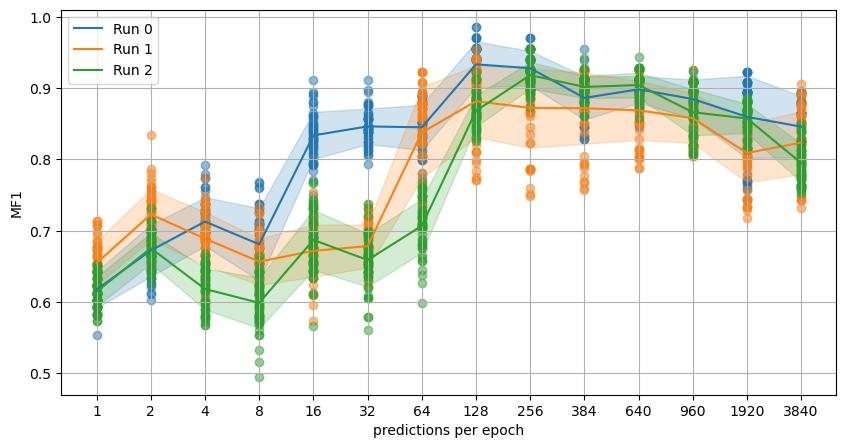

In [5]:
plt.figure(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for i, (model_run, mf1_scores_epoch) in enumerate(mf1_scores.items()):
    c = colors[i % len(colors)]
    means_to_plot = np.array(list(mf1_scores_epoch.values())).mean(axis=1)
    stds_to_plot = np.array(list(mf1_scores_epoch.values())).std(axis=1)
    plt.plot(range(len(mf1_scores_epoch)), means_to_plot, label=f"Run {i}", color=c)
    plt.fill_between(range(len(mf1_scores_epoch)), means_to_plot - stds_to_plot, means_to_plot + stds_to_plot,
                     alpha=0.2, color=c)
    plt.scatter(np.repeat(range(len(mf1_scores_epoch)), n_exps), np.array(list(mf1_scores_epoch.values())).flatten(),
                alpha=0.5, color=c)
first_key = next(iter(mf1_scores))
plt.xticks(range(len(mf1_scores[first_key])), list(mf1_scores[first_key].keys()))
plt.grid()
plt.xlabel("predictions per epoch")
plt.ylabel("MF1")
plt.legend()
plt.show()